In [2]:
import os, glob
import pandas as pd
import json

In [4]:
train = pd.read_json('../../data/xstance/train.jsonl', lines=True)
train

,id,language,question_id,question,comment,label,numerical_label,author,topic
0,3808,de,44,"Eine Volksinitiative fordert, dass die Gesamtf...","Eine fixe Grösse verbieten, ist das falsche Mi...",AGAINST,25,20a4c510b64f,Infrastructure & Environment
1,10045,de,739,Sind Sie für eine vollständige Liberalisierung...,Das Arbeitsgesetz regelt die Arbeitszeiten und...,FAVOR,100,f27b54a137b4,Economy
2,10099,de,739,Sind Sie für eine vollständige Liberalisierung...,"Es muss jedoch sicher gestellt werden, dass di...",FAVOR,100,4fab6443143e,Economy
3,10146,de,739,Sind Sie für eine vollständige Liberalisierung...,Die realisierten Liberalisierungen habe ich be...,AGAINST,0,a9f7e55858de,Economy
4,10252,de,739,Sind Sie für eine vollständige Liberalisierung...,"Wenn ein Bedarf dafür besteht, ja. Allerdings ...",FAVOR,75,5ea292041495,Economy
...,...,...,...,...,...,...,...,...,...
45635,168394,fr,12,Approuvez-vous que des dispenses scolaires soi...,"Séparation de l'Etat et de la religion, pas de...",AGAINST,0,80ebaa906d20,Education
45636,168412,fr,12,Approuvez-vous que des dispenses scolaires soi...,"Par principe j'y suis plutôt opposé, cependant...",AGAINST,25,086f43f2bf52,Education
45637,206060,fr,12,Approuvez-vous que des dispenses scolaires soi...,Nous devons respecter coute que coute la laïci...,AGAINST,0,983d48ac9282,Education
45638,206088,fr,12,Approuvez-vous que des dispenses scolaires soi...,Non. Il est important que l'école demeure laïq...,AGAINST,0,4cbe2a34da39,Education


In [ ]:
train['topic'].value_counts()

topic
Infrastructure & Environment    7059
Welfare                         6537
Education                       6002
Economy                         5555
Immigration                     4681
Society                         4578
Security                        3797
Foreign Policy                  3465
Finances                        3030
Digitisation                     936
Name: count, dtype: int64

---

In [10]:
test_preds = pd.read_csv('../../predictions/xstance_test_preds.csv')

test_preds.groupby('language')[['label', 'prediction']]\
    .apply(lambda x: (x['label'] == x['prediction'])\
           .mean())\
            .reset_index()\
                .rename(columns={0: 'accuracy'})

,language,accuracy
0,de,0.711547
1,fr,0.728938
2,it,0.720609


In [19]:
test_preds = test_preds.groupby(['topic', 'language'])[['label', 'prediction']]\
    .apply(lambda x: (x['label'] == x['prediction']).mean())\
    .reset_index()\
    .pivot(index='topic', columns='language', values=0)

test_preds

language,de,fr,it
topic,,,
Digitisation,0.726190,0.692308,0.842105
Economy,0.710579,0.738318,0.713376
Education,0.753425,0.816176,0.732394
Finances,0.687793,0.713235,0.685393
Foreign Policy,0.652074,0.701299,0.750000
Healthcare,0.704787,0.708229,0.709677
Immigration,0.696970,0.683019,0.756098
Infrastructure & Environment,0.723674,0.757764,0.688119
Political System,0.715650,0.760900,0.693878


In [40]:
import numpy as np
import matplotlib.pyplot as plt

def plot(df):
    topics = df.index
    languages = df.columns
    x = np.arange(len(topics))  # label locations
    width = 0.2  # bar width

    fig, ax = plt.subplots(figsize=(12, 6))
    colors = {'de': 'indianred', 'fr': 'royalblue', 'it': 'seagreen'}

    # Plot bars for each language
    for i, lang in enumerate(languages):
        ax.bar(x + i * width, df[lang], width, color=colors[lang], label=lang)

    ax.set_xlabel("Topic")
    ax.set_ylabel("Accuracy")
    ax.set_title("Accuracy by Topic and Language")
    ax.set_xticks(x + width, topics, rotation=45, ha="right")
    ax.legend(loc='upper center', ncol=len(languages))
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()

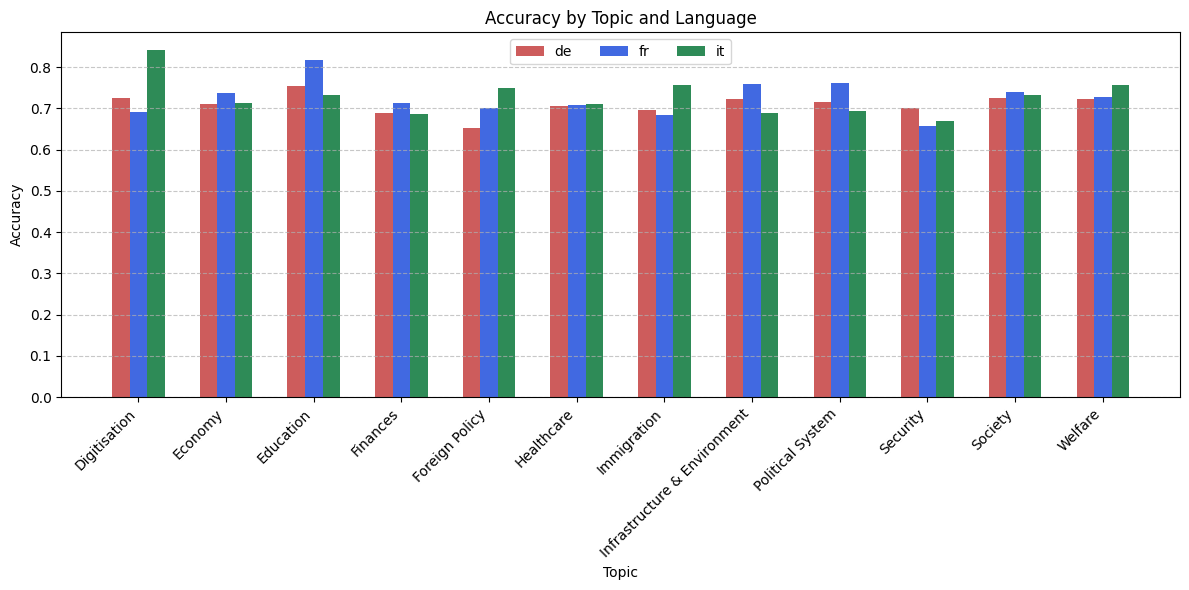

In [41]:
plot(test_preds)

In [15]:
def plot_metrics(model_dir):
    last_ckpt = os.path.join(glob.glob(os.path.join(model_dir, '*'))[-1], 'trainer_state.json')

    with open(last_ckpt, 'r') as file:
        data = json.load(file)

    log_history = (pd.DataFrame(data['log_history'])
                .groupby("epoch")
                .agg(lambda x: x.dropna().iloc[0] if not x.dropna().empty else None)
                .reset_index())
    
    log_history.plot(x='epoch', 
                     y=['eval_accuracy', 'eval_loss', 'loss'], 
                     label=['Validation Accuracy', 'Validation Loss', 'Training Loss'], 
                     color=['green', 'red', 'maroon'], 
                     grid=True
                     )

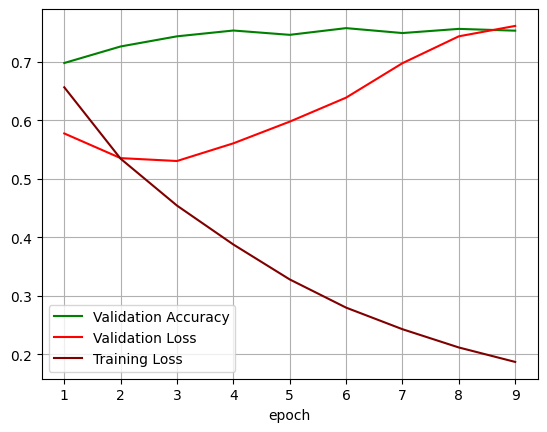

In [20]:
model_dir = "../../models/binary_stance_classifier/"
plot_metrics(model_dir)


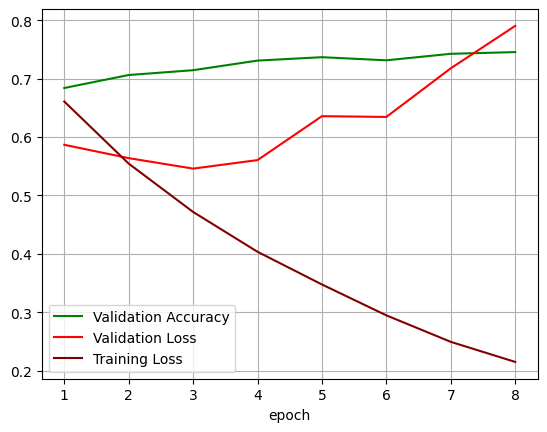

In [17]:
model_dir = "../../models/XLM-R_stance_classifier/"
plot_metrics(model_dir)

---
Performance on train and validation sets

In [32]:
train_preds = pd.read_csv('predictions/xstance_train_preds.csv')

train_preds.groupby('language')[['label', 'prediction']]\
    .apply(lambda x: (x['label'] == x['prediction'])\
           .mean())\
            .reset_index()\
                .rename(columns={0: 'accuracy'})

,language,accuracy
0,de,0.809897
1,fr,0.964716


In [31]:
val_preds = pd.read_csv('predictions/xstance_valid_preds.csv')

val_preds.groupby('language')[['label', 'prediction']]\
    .apply(lambda x: (x['label'] == x['prediction'])\
           .mean())\
            .reset_index()\
                .rename(columns={0: 'accuracy'})

,language,accuracy
0,de,0.713689
1,fr,0.763981
